In [1]:
from time import perf_counter
import os
from joblib import Parallel, delayed
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt

from src import utils
from src import models

SEED = 10
N_CPUS = os.cpu_count()

np.random.seed(SEED)

In [2]:
def run_experiment(g, Exps, graph_p, signal_p, verb):
    Adj_list = utils.create_dinamic_graph(**graph_p)
    X_list, X0 = utils.create_dinamic_gmrf_signals(Adj_list, **signal_p)

    n_iters = np.array( [X_i.shape[1] for X_i in X_list] ).sum() + len(X_list)

    err_graphs = np.zeros((len(Adj_list), len(Exps)))
    err_seq = np.zeros((n_iters, len(Exps)))
    err_first = np.zeros_like(err_graphs)
    runtime = np.zeros(len(Exps))
    for i, exp in enumerate(Exps):
        model = exp['model'](**exp['init'])
        t_init = perf_counter()
        model.fit(X_list, **exp['args'])
        t_end = perf_counter()

        err_graphs[:,i] = model.test_err(Adj_list)
        err_seq[:,i] = model.test_sequence_err(Adj_list)
        err_first[:,i] = model.test_err_graph_i(Adj_list, 0)
        runtime[i] = t_end - t_init

        if verb and g % N_CPUS == 0:
            print(f'- {g+1}. {exp["leg"]}: Err 1st graph: {err_graphs[0,i]:.3f}   -   Err last graph: {err_graphs[-1,i]:.3f}   ' +\
                  f'-   time: {runtime[i]:.3f} secs')

    return err_graphs, err_seq, err_first, runtime


def plot_all_results(exps, err_graphs, err_seq, err_first, graph_p):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Compute growing number of nodes
    graph_dims = np.ones(len(graph_p['new_nodes']) + 1) * graph_p['n_nodes']
    for i, new_nodes in enumerate(graph_p['new_nodes']):
        graph_dims[i+1] = graph_dims[i] + new_nodes

    utils.plot_data(axes[0], err_graphs, exps, graph_dims, 'Number of nodes', 'Error growing graph', deviation='prctile')
    utils.plot_data(axes[1], err_first, exps, graph_dims, 'Number of nodes', 'Error 1st block', deviation='prctile')
    utils.plot_data(axes[2], err_seq, exps, np.arange(err_seq[0].shape[0]), 'Number of nodes', 'Error seq', deviation='prctile')
    plt.tight_layout()


In [5]:
# Default experiment parameters and auxiliary funcitons
## Graph parameters
n_graphs = 50
N = 50
graph_p = {
    'n_nodes': N,
    'edges': N*4,
    'graph_type': 'er',
    'edge_type': 'positive',
    'new_nodes': [2]*75,
    'new_edges': 4,
    'load_adjs_fact': .01, #.01,
    'conn_nodes': True,
}

## Signal parameters
signal_p = {
    'samples_t': [1000] + [50]*75,
    'noise_power': .05,
}

stepsize = 5e-3
lamb = 1e-2
gamma = .95
eps = .1
alpha = 0
verb = True

Exps = [
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 'args': {'lamb': lamb, 'stepsize': stepsize, 'gamma': gamma, 
     'epsilon': eps, 'alpha': alpha}, 'leg': 'Incr', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic'}, 'args': {'lamb': lamb, 'stepsize': stepsize, 'gamma': gamma,
     'epsilon': eps, 'alpha': alpha}, 'leg': 'dynamic', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'stationary'}, 'args': {'lamb': lamb, 'stepsize': stepsize}, 'leg': 'stationary',
     'fmt': '-'}
]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_experiment)(g, Exps, graph_p, signal_p, verb) for g in range(n_graphs))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

err_graphs, err_seq, err_first, runtime = zip(*results)
# err_graphs, err_seq, err_first = [np.zeros((n_dags, len(Sizes), len(Exps)))  for _ in range(8)]

CPUs employed: 128
- 1. Incr: Err 1st graph: 0.180   -   Err last graph: 0.331   -   time: 10.206 secs
- 1. dynamic: Err 1st graph: 0.236   -   Err last graph: 0.334   -   time: 10.164 secs
- 1. stationary: Err 1st graph: 0.164   -   Err last graph: 0.453   -   time: 9.956 secs
----- Solved in 0.554 minutes -----


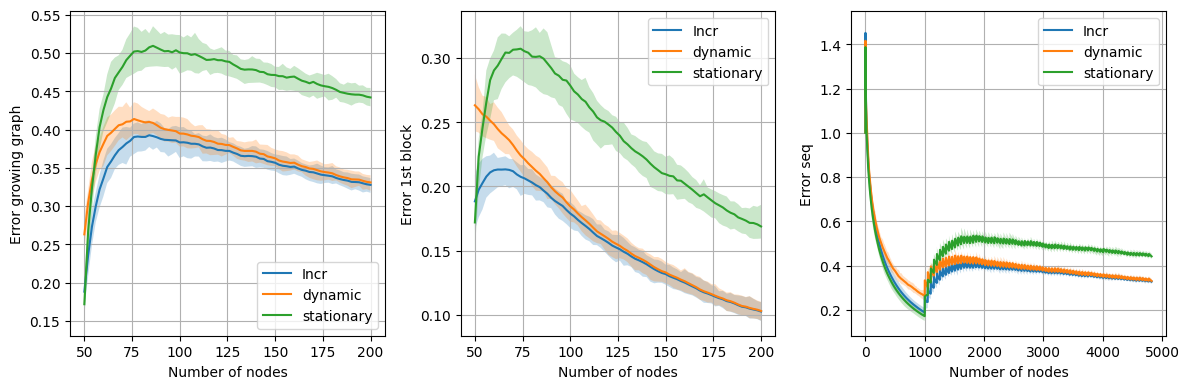

In [6]:
plot_all_results(Exps, err_graphs, err_seq, err_first, graph_p)

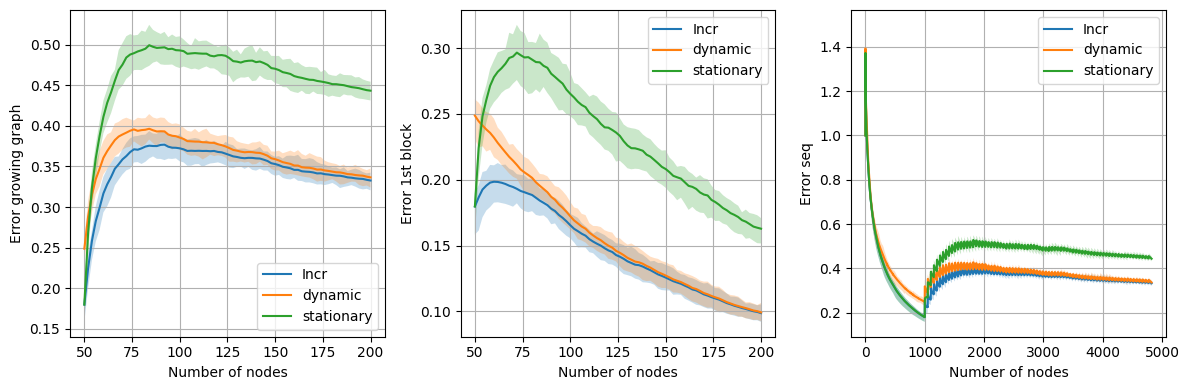

In [12]:
# N = 50
# graph_p = {
#     'n_nodes': N,
#     'edges': N*4,
#     'graph_type': 'er',
#     'edge_type': 'positive',
#     'new_nodes': [2]*75,
#     'new_edges': 4,
#     'load_adjs_fact': .01, #.01,
#     'conn_nodes': True,
# }

# ## Signal parameters
# signal_p = {
#     'samples_t': [1000] + [50]*75,
#     'noise_power': .05,
# }

# stepsize = 5e-3
# lamb = 1e-2
# gamma = .95
# eps = .01
# alpha = 0
# verb = True


plot_all_results(Exps, err_graphs, err_seq, err_first, graph_p)

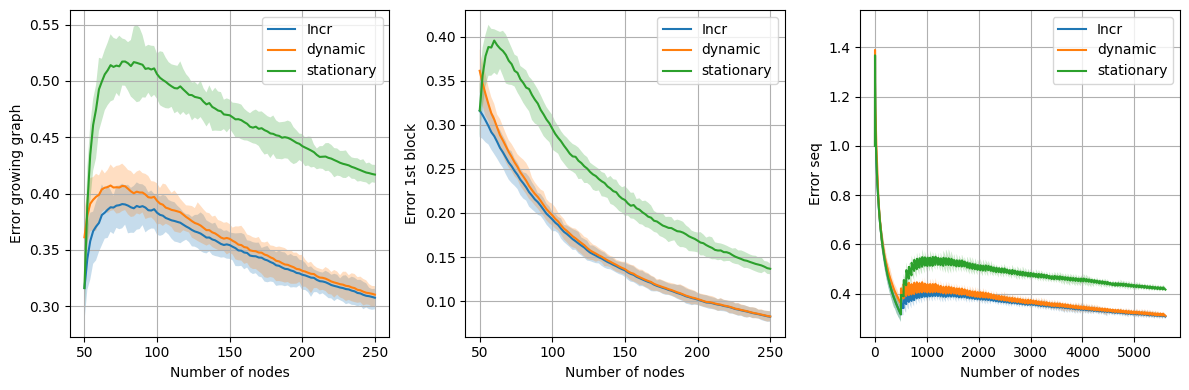

In [6]:
# Setiting "facil" (1000 muestras)
plot_all_results(Exps, err_graphs, err_seq, err_first, graph_p)

In [7]:
# Default experiment parameters and auxiliary funcitons
## Graph parameters
n_graphs = 20
N = 50
graph_p = {
    'n_nodes': N,
    'edges': N*4,
    'graph_type': 'er',
    'edge_type': 'positive',
    'new_nodes': [1]*5,
    'new_edges': 4*3,
    'load_adjs_fact': .1,
    'conn_nodes': False,
}

## Signal parameters
signal_p = {
    'samples_t': 1000,
    'noise_power': .05,
}

stepsize = 5e-3
lamb = 1e-2
gamma = .95
alpha = 0
verb = True

Exps = [
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 'args': {'lamb': lamb, 'stepsize': stepsize, 'gamma': gamma, 'alpha': alpha},
     'leg': 'Incr', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic'}, 'args': {'lamb': lamb, 'stepsize': stepsize, 'gamma': gamma, 'alpha': alpha},
     'leg': 'dynamic', 'fmt': '-'},
    # {'model': models.Online_dyn_nti, 'init': {'cov_update': 'stationary'}, 'args': {'lamb': lamb, 'stepsize': stepsize}, 'leg': 'stationary',
    #  'fmt': '-'}
]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_experiment)(g, Exps, graph_p, signal_p, verb) for g in range(n_graphs))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

err_graphs, err_seq, err_first, runtime = zip(*results)
# err_graphs, err_seq, err_first = [np.zeros((n_dags, len(Sizes), len(Exps)))  for _ in range(8)]

CPUs employed: 128
- 1. Incr: Err 1st graph: 0.114   -   Err last graph: 0.119   -   time: 2.713 secs
- 1. dynamic: Err 1st graph: 0.159   -   Err last graph: 0.115   -   time: 2.417 secs
----- Solved in 0.095 minutes -----


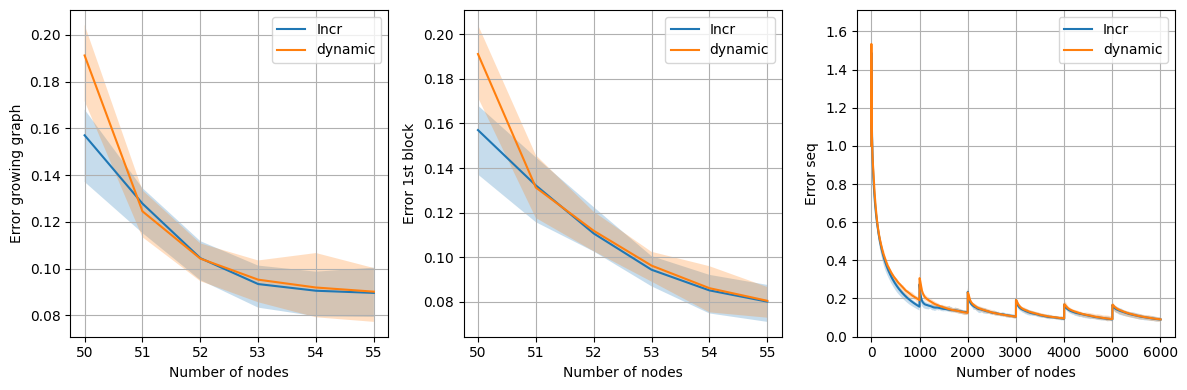

In [8]:
plot_all_results(Exps, err_graphs, err_seq, err_first, graph_p)